# Matching Networks: Omniglot Dataset

In this tutorial, we will learn how to create Matching Networks, and train it on Omniglot Dataset.


##### Step 1: Import all necessary libraries 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline 

#### Step 2: We will load omniglot dataset, tranformed in .npy format using helper script.  

In [2]:
x = np.load('data/data.npy') # Load Data
x = np.reshape(x, newshape=(x.shape[0], x.shape[1], 28, 28, 1)) # Reshape data to compress it to 28X28 
np.random.shuffle(x) # shuffle dataset
x_train, x_val, x_test = x[:1200], x[1200:1411], x[1411:] # divide dataset in to train,val,test
batch_size = 16 # setting batch_size
n_classes = x.shape[0] # number of classes
classes_per_set = 20 # number of classes per-set
samples_per_class = 1 # as we are choosing it to be one shot learning, so we have 1 sample
indexes = {"train": 0, "val": 0, "test": 0}

##### Preprocess Images: Here we have use normalization method. 

In [3]:
def processes_batch(data, mu, sigma):
    return (data - mu) / sigma

# Normalize Dataset
x_train = processes_batch(x_train, np.mean(x_train), np.std(x_train))
x_val = processes_batch(x_val, np.mean(x_val), np.std(x_val))
x_test = processes_batch(x_test, np.mean(x_test), np.std(x_test))

# Defining dictionary of dataset
datatset = {"train": x_train, "val": x_val, "test": x_test}

###### Step 3: Sample Batch Processing
To Load Omniglot dataset, and prepare it for Matching Networks Architecture, we need to create:
1. Label Set 
2. Support Set
3. Batch from Suppport Set Examples

Let's first create a batch which can give a support set, and a target.

In [4]:
def sample_batch(data):
        """
        Collect 1000 batches data for N-shot learning
        :param data_pack: one of(train,test,val) dataset shape[classes_num,20,28,28,1]
        :return: A list with [support_set_x,support_set_y,target_x,target_y] ready to be fed to our networks
        """
        support_set_x = np.zeros((batch_size, classes_per_set, samples_per_class, data.shape[2],
                                  data.shape[3], data.shape[4]), np.float32)
        support_set_y = np.zeros((batch_size, classes_per_set, samples_per_class), np.int32)
        target_x = np.zeros((batch_size, data.shape[2], data.shape[3], data.shape[4]), np.float32)
        target_y = np.zeros((batch_size, 1), np.int32)

        for i in range(batch_size):
            classes_idx = np.arange(data.shape[0])
            samples_idx = np.arange(data.shape[1])
            choose_classes = np.random.choice(classes_idx, size=classes_per_set, replace=False)
            choose_label = np.random.choice(classes_per_set, size=1)
            choose_samples = np.random.choice(samples_idx, size=samples_per_class + 1, replace=False)

            x_temp = data[choose_classes]
            x_temp = x_temp[:, choose_samples]
            y_temp = np.arange(classes_per_set)
            support_set_x[i] = x_temp[:, :-1]
            support_set_y[i] = np.expand_dims(y_temp[:], axis=1)
            target_x[i] = x_temp[choose_label, -1]
            target_y[i] = y_temp[choose_label]
        return support_set_x, support_set_y, target_x, target_y
    
def _get_batch(dataset_name):
        """
        Get next batch from the dataset with name.
        :param dataset_name: The name of dataset(one of "train","val","test")
        :param augment: if rotate the images
        :return: a batch images
        """
        support_set_x, support_set_y, target_x, target_y = sample_batch(datatset[dataset_name])
        support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                               support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
        support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])
        return support_set_x, support_set_y, target_x, target_y
    

If you recall, Matching Networks architecture, you will remember that there are mainly 3 parts of network:
1. Classifer
2. Attention Model
3. Distance Function

so, In this section first we will create a classifier.

##### Step 4: Create a Classifier  

In [5]:
def convLayer(in_channels, out_channels, keep_prob=0.0):
    """3*3 convolution with padding,ever time call it the output size become half"""
    cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(keep_prob)
    )
    return cnn_seq

class Classifier(nn.Module):
    def __init__(self, layer_size=64, num_channels=1, keep_prob=1.0, image_size=28):
        super(Classifier, self).__init__()
        """
        Build a CNN to produce embeddings
        :param layer_size:64(default)
        :param num_channels:
        :param keep_prob:
        :param image_size:
        """
        self.layer1 = convLayer(num_channels, layer_size, keep_prob)
        self.layer2 = convLayer(layer_size, layer_size, keep_prob)
        self.layer3 = convLayer(layer_size, layer_size, keep_prob)
        self.layer4 = convLayer(layer_size, layer_size, keep_prob)

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2)))
        self.outSize = finalSize * finalSize * layer_size

    def forward(self, image_input):
        """
        Use CNN defined above
        :param image_input:
        :return:
        """
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size()[0], -1)
        return x


##### step 5: Create an Attention model after classifier.

In [6]:
class AttentionalClassify(nn.Module):
    def __init__(self):
        super(AttentionalClassify, self).__init__()

    def forward(self, similarities, support_set_y):
        """
        Products pdfs over the support set classes for the target set image.
        :param similarities: A tensor with cosine similarites of size[batch_size,sequence_length]
        :param support_set_y:[batch_size,sequence_length,classes_num]
        :return: Softmax pdf shape[batch_size,classes_num]
        """
        softmax = nn.Softmax()
        softmax_similarities = softmax(similarities)
        preds = softmax_similarities.unsqueeze(1).bmm(support_set_y).squeeze()
        return preds

#### Step 6: Create a Distance Network, which will take output from Test Image, and training embeddings, to calculate the Distance.

In [7]:
class DistanceNetwork(nn.Module):
    """
    This model calculates the cosine distance between each of the support set embeddings and the target image embeddings.
    """

    def __init__(self):
        super(DistanceNetwork, self).__init__()

    def forward(self, support_set, input_image):
        """
        forward implement
        :param support_set:the embeddings of the support set images.shape[sequence_length,batch_size,64]
        :param input_image: the embedding of the target image,shape[batch_size,64]
        :return:shape[batch_size,sequence_length]
        """
        eps = 1e-10
        similarities = []
        for support_image in support_set:
            sum_support = torch.sum(torch.pow(support_image, 2), 1)
            support_manitude = sum_support.clamp(eps, float("inf")).rsqrt()
            dot_product = input_image.unsqueeze(1).bmm(support_image.unsqueeze(2)).squeeze()
            cosine_similarity = dot_product * support_manitude
            similarities.append(cosine_similarity)
        similarities = torch.stack(similarities)
        return similarities.t()

##### Step 7:  Create a Bi-directional LSTM, which is taking input and output from Test-image, and put them in same embeddings space.  

In [8]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, layer_size, batch_size, vector_dim):
        super(BidirectionalLSTM, self).__init__()
        """
        Initial a muti-layer Bidirectional LSTM
        :param layer_size: a list of each layer'size
        :param batch_size: 
        :param vector_dim: 
        """
        self.batch_size = batch_size
        self.hidden_size = layer_size[0]
        self.vector_dim = vector_dim
        self.num_layer = len(layer_size)
        self.lstm = nn.LSTM(input_size=self.vector_dim, num_layers=self.num_layer, hidden_size=self.hidden_size,
                            bidirectional=True)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),requires_grad=False),
                Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size),requires_grad=False))

    def repackage_hidden(self,h):
        """Wraps hidden states in new Variables, to detach them from their history."""
        if type(h) == Variable:
            return Variable(h.data)
        else:
            return tuple(self.repackage_hidden(v) for v in h)

    def forward(self, inputs):
        self.hidden = self.repackage_hidden(self.hidden)
        output, self.hidden = self.lstm(inputs, self.hidden)
        return output

##### Step 8: Let's club all small modules we made, and create a matching network. 

In [9]:
class MatchingNetwork(nn.Module):
    def __init__(self, keep_prob, batch_size=32, num_channels=1, learning_rate=1e-3, fce=False, num_classes_per_set=20, \
                 num_samples_per_class=1, image_size=28):
        """
        This is our main network
        :param keep_prob: dropout rate
        :param batch_size:
        :param num_channels:
        :param learning_rate:
        :param fce: Flag indicating whether to use full context embeddings(i.e. apply an LSTM on the CNN embeddings)
        :param num_classes_per_set:
        :param num_samples_per_class:
        :param image_size:
        """
        super(MatchingNetwork, self).__init__()
        self.batch_size = batch_size
        self.keep_prob = keep_prob
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.fce = fce
        self.num_classes_per_set = num_classes_per_set
        self.num_samples_per_class = num_samples_per_class
        self.image_size = image_size
        self.g = Classifier(layer_size=64, num_channels=num_channels, keep_prob=keep_prob, image_size=image_size)
        self.dn = DistanceNetwork()
        self.classify = AttentionalClassify()
        if self.fce:
            self.lstm = BidirectionalLSTM(layer_size=[32], batch_size=self.batch_size, vector_dim=self.g.outSize)

    def forward(self, support_set_images, support_set_y_one_hot, target_image, target_y):
        """
        Main process of the network
        :param support_set_images: shape[batch_size,sequence_length,num_channels,image_size,image_size]
        :param support_set_y_one_hot: shape[batch_size,sequence_length,num_classes_per_set]
        :param target_image: shape[batch_size,num_channels,image_size,image_size]
        :param target_y:
        :return:
        """
        # produce embeddings for support set images
        encoded_images = []
        for i in np.arange(support_set_images.size(1)):
            gen_encode = self.g(support_set_images[:, i, :, :])
            encoded_images.append(gen_encode)

        # produce embeddings for target images
        gen_encode = self.g(target_image)
        encoded_images.append(gen_encode)
        output = torch.stack(encoded_images)
        # use fce?
        if self.fce:
            outputs = self.lstm(output)

        # get similarities between support set embeddings and target
        similarites = self.dn(support_set=output[:-1], input_image=output[-1])

        # produce predictions for target probabilities
        preds = self.classify(similarites, support_set_y=support_set_y_one_hot)

        # calculate the accuracy
        values, indices = preds.max(1)
        accuracy = torch.mean((indices.squeeze() == target_y).float())
        crossentropy_loss = F.cross_entropy(preds, target_y.long())

        return accuracy, crossentropy_loss

#### Step 9: Create a Dataset Loader.
For our case, as we are using Omniglot Dataset,it will create a Omnligloat builder which calls Matching Network, and run its epochs for training, testing, and validation purpose.

In [10]:
class OmniglotBuilder:
    def build_experiment(self, batch_size, num_channels, lr, image_size, classes_per_set, samples_per_class, keep_prob,
                         fce, optim, weight_decay):
        """

        :param batch_size:
        :param num_channels:
        :param lr:
        :param image_size:
        :param classes_per_set:
        :param samples_per_class:
        :param keep_prob:
        :param fce:
        :param optim:
        :param weight_decay:
        :param use_cuda:
        :return:
        """
        self.classes_per_set = classes_per_set
        self.sample_per_class = samples_per_class
        self.keep_prob = keep_prob
        self.batch_size = batch_size
        self.lr = lr
        self.image_size = image_size
        self.optim = optim
        self.wd = weight_decay
        self.matchNet = MatchingNetwork(keep_prob, batch_size, num_channels, self.lr, fce, classes_per_set,
                                        samples_per_class, image_size)
        self.total_iter = 0
        self.total_train_iter = 0
        self.optimizer = torch.optim.Adam(self.matchNet.parameters(), lr=self.lr, weight_decay=self.wd)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min',verbose=True)

    def run_training_epoch(self, total_train_batches):
        """
        Run the training epoch
        :param total_train_batches: Number of batches to train on
        :return:
        """
        total_c_loss = 0.0
        total_accuracy = 0.0
        with tqdm.tqdm(total=total_train_batches) as pbar:
            for i in range(total_train_batches):
                x_support_set, y_support_set, x_target, y_target = _get_batch("train")
                x_support_set = Variable(torch.from_numpy(x_support_set)).float()
                y_support_set = Variable(torch.from_numpy(y_support_set), requires_grad=False).long()
                x_target = Variable(torch.from_numpy(x_target)).float()
                y_target = Variable(torch.from_numpy(y_target), requires_grad=False).squeeze().long()

                # convert to one hot encoding
                y_support_set = y_support_set.unsqueeze(2)
                sequence_length = y_support_set.size()[1]
                batch_size = y_support_set.size()[0]
                y_support_set_one_hot = Variable(
                    torch.zeros(batch_size, sequence_length, self.classes_per_set).scatter_(2,
                                                                                            y_support_set.data,
                                                                                            1), requires_grad=False)

                # reshape channels and change order
                size = x_support_set.size()
                x_support_set = x_support_set.permute(0, 1, 4, 2, 3)
                x_target = x_target.permute(0, 3, 1, 2)
                acc, c_loss = self.matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)

                # optimize process
                self.optimizer.zero_grad()
                c_loss.backward()
                self.optimizer.step()

                # TODO: update learning rate?

                iter_out = "tr_loss: {}, tr_accuracy: {}".format(c_loss.data[0], acc.data[0])
                pbar.set_description(iter_out)
                pbar.update(1)
                total_c_loss += c_loss.data[0]
                total_accuracy += acc.data[0]
                # self.total_train_iter+=1

            total_c_loss = total_c_loss / total_train_batches
            total_accuracy = total_accuracy / total_train_batches
            return total_c_loss, total_accuracy

    def run_val_epoch(self, total_val_batches):
        """
        Run the training epoch
        :param total_train_batches: Number of batches to train on
        :return:
        """
        total_c_loss = 0.0
        total_accuracy = 0.0

        with tqdm.tqdm(total=total_val_batches) as pbar:
            for i in range(total_val_batches):
                x_support_set, y_support_set, x_target, y_target = _get_batch("val")
                x_support_set = Variable(torch.from_numpy(x_support_set)).float()
                y_support_set = Variable(torch.from_numpy(y_support_set), requires_grad=False).long()
                x_target = Variable(torch.from_numpy(x_target)).float()
                y_target = Variable(torch.from_numpy(y_target), requires_grad=False).squeeze().long()

                # convert to one hot encoding
                y_support_set = y_support_set.unsqueeze(2)
                sequence_length = y_support_set.size()[1]
                batch_size = y_support_set.size()[0]
                y_support_set_one_hot = Variable(
                    torch.zeros(batch_size, sequence_length, self.classes_per_set).scatter_(2,
                                                                                            y_support_set.data,
                                                                                            1), requires_grad=False)

                # reshape channels and change order
                size = x_support_set.size()
                x_support_set = x_support_set.permute(0, 1, 4, 2, 3)
                x_target = x_target.permute(0, 3, 1, 2)
                acc, c_loss = self.matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)

                # TODO: update learning rate?

                iter_out = "val_loss: {}, val_accuracy: {}".format(c_loss.data[0], acc.data[0])
                pbar.set_description(iter_out)
                pbar.update(1)
                total_c_loss += c_loss.data[0]
                total_accuracy += acc.data[0]
                # self.total_train_iter+=1

            total_c_loss = total_c_loss / total_val_batches
            total_accuracy = total_accuracy / total_val_batches
            self.scheduler.step(total_c_loss)
            return total_c_loss, total_accuracy

    def run_test_epoch(self, total_test_batches):
        """
        Run the training epoch
        :param total_train_batches: Number of batches to train on
        :return:
        """
        total_c_loss = 0.0
        total_accuracy = 0.0

        with tqdm.tqdm(total=total_test_batches) as pbar:
            for i in range(total_test_batches):
                x_support_set, y_support_set, x_target, y_target = _get_batch("test")
                x_support_set = Variable(torch.from_numpy(x_support_set)).float()
                y_support_set = Variable(torch.from_numpy(y_support_set), requires_grad=False).long()
                x_target = Variable(torch.from_numpy(x_target)).float()
                y_target = Variable(torch.from_numpy(y_target), requires_grad=False).squeeze().long()

                # convert to one hot encoding
                y_support_set = y_support_set.unsqueeze(2)
                sequence_length = y_support_set.size()[1]
                batch_size = y_support_set.size()[0]
                y_support_set_one_hot = Variable(
                    torch.zeros(batch_size, sequence_length, self.classes_per_set).scatter_(2,
                                                                                            y_support_set.data,
                                                                                            1), requires_grad=False)

                # reshape channels and change order
                size = x_support_set.size()
                x_support_set = x_support_set.permute(0, 1, 4, 2, 3)
                x_target = x_target.permute(0, 3, 1, 2)
                acc, c_loss = self.matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)

                # TODO: update learning rate?

                iter_out = "val_loss: {}, val_accuracy: {}".format(c_loss.data[0], acc.data[0])
                pbar.set_description(iter_out)
                pbar.update(1)
                total_c_loss += c_loss.data[0]
                total_accuracy += acc.data[0]
                # self.total_train_iter+=1

            total_c_loss = total_c_loss / total_test_batches
            total_accuracy = total_accuracy / total_test_batches
            return total_c_loss, total_accuracy

###### Set-up Experiments variables.

In [11]:
# Experiment setup
batch_size = 20
fce = True
classes_per_set = 20
samples_per_class = 1
channels = 1
# Training setup
total_epochs = 5
total_train_batches = 50
total_val_batches = 10
total_test_batches = 15
best_val_acc = 0.0

data = "data"
obj_oneShotBuilder = OmniglotBuilder()
obj_oneShotBuilder.build_experiment(batch_size=batch_size, num_channels=1, lr=1e-3, image_size=28, classes_per_set=20,
                                    samples_per_class=1, keep_prob=0.0, fce=True, optim="adam", weight_decay=0)

##### Let's Run Experiments !!!!! 

In [12]:
train_loss,train_accuracy=[],[]
val_loss,val_accuracy=[],[]
test_loss,test_accuracy=[],[]


for e in range(total_epochs):
    ############################### Training Step ##########################################
    total_c_loss, total_accuracy = obj_oneShotBuilder.run_training_epoch(total_train_batches)
    train_loss.append(total_c_loss)
    train_accuracy.append(total_accuracy)
    print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, total_c_loss, total_accuracy))
    
    ################################# Validation Step #######################################
    total_val_c_loss, total_val_accuracy = obj_oneShotBuilder.run_val_epoch(total_val_batches)
    val_loss.append(total_val_c_loss)
    val_accuracy.append(total_val_accuracy)
    print("Epoch {}: val_loss:{} val_accuracy:{}".format(e, total_val_c_loss, total_val_accuracy))
    
    ############################# Test Accuracy check ###########################################
    if total_val_accuracy>best_val_acc:
        best_val_acc = total_val_accuracy
        total_test_c_loss, total_test_accuracy = obj_oneShotBuilder.run_test_epoch(total_test_batches)
        test_loss.append(total_test_c_loss)
        test_accuracy.append(total_test_accuracy)
        print("Epoch {}: test_loss:{} test_accuracy:{}".format(e, total_test_c_loss, total_test_accuracy))

  0%|          | 0/50 [00:00<?, ?it/s]/Users/sjadon/anaconda3/envs/meta/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
tr_loss: 2.65885281563, tr_accuracy: 0.550000011921: 100%|██████████| 50/50 [01:09<00:00,  1.34s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: train_loss:2.82077505589 train_accuracy:0.356999999136


val_loss: 2.77489423752, val_accuracy: 0.34999999404: 100%|██████████| 10/10 [00:06<00:00,  1.39it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0: val_loss:2.76967451572 val_accuracy:0.389999994636


val_loss: 2.68702745438, val_accuracy: 0.550000011921: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: test_loss:2.76442271868 test_accuracy:0.406666666269


tr_loss: 2.69032239914, tr_accuracy: 0.550000011921: 100%|██████████| 50/50 [01:06<00:00,  1.35s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: train_loss:2.70877521992 train_accuracy:0.475000000596


val_loss: 2.71750736237, val_accuracy: 0.449999988079: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: val_loss:2.69341108799 val_accuracy:0.459999999404


val_loss: 2.73027157784, val_accuracy: 0.34999999404: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s] 
  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: test_loss:2.72069067955 test_accuracy:0.453333330154


tr_loss: 2.72659921646, tr_accuracy: 0.449999988079: 100%|██████████| 50/50 [01:14<00:00,  1.52s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: train_loss:2.63900801659 train_accuracy:0.561000002623


val_loss: 2.53763866425, val_accuracy: 0.600000023842: 100%|██████████| 10/10 [00:07<00:00,  1.44it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2: val_loss:2.62926092148 val_accuracy:0.535000005364


val_loss: 2.59837388992, val_accuracy: 0.550000011921: 100%|██████████| 15/15 [00:10<00:00,  1.52it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2: test_loss:2.61301784515 test_accuracy:0.593333337704


tr_loss: 2.58672595024, tr_accuracy: 0.600000023842: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: train_loss:2.61339054108 train_accuracy:0.577000002861


val_loss: 2.68092870712, val_accuracy: 0.40000000596: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3: val_loss:2.56358880997 val_accuracy:0.605000010133


val_loss: 2.58609819412, val_accuracy: 0.600000023842: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]
  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3: test_loss:2.57351250648 test_accuracy:0.610000004371


tr_loss: 2.49018526077, tr_accuracy: 0.649999976158: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4: train_loss:2.54416198254 train_accuracy:0.631999998689


val_loss: 2.53471636772, val_accuracy: 0.550000011921: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4: val_loss:2.53294935226 val_accuracy:0.675


val_loss: 2.62239050865, val_accuracy: 0.5: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]           

Epoch 4: test_loss:2.53339729309 test_accuracy:0.663333332539


#### Step 10: Let's visualize our results 

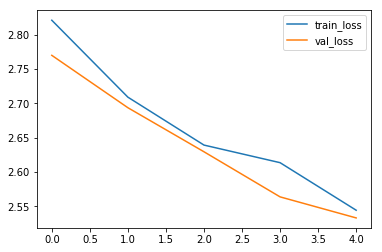

In [13]:
def plot_loss(train,val,name1="train_loss",name2="val_loss"):
    plt.plot(train, label=name1)
    plt.plot(val, label=name2)
    plt.legend()

plot_loss(train_loss,val_loss)
    


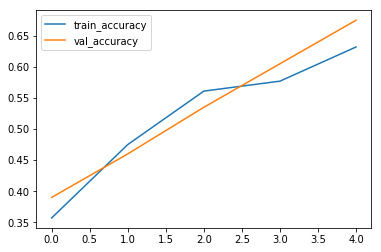

In [14]:
plot_loss(train_accuracy,val_accuracy,"train_accuracy","val_accuracy")

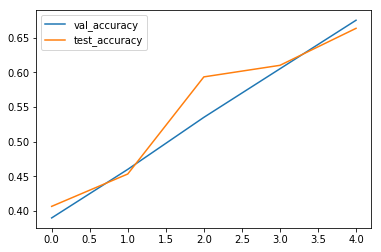

In [15]:
plot_loss(val_accuracy,test_accuracy,"val_accuracy","test_accuracy")

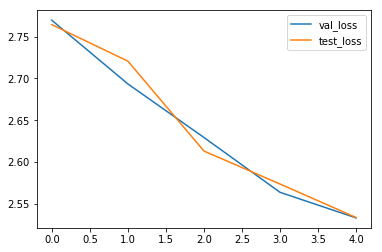

In [16]:
plot_loss(val_loss,test_loss,"val_loss","test_loss")